This notebook makes all of the figures that were on my burrito analysis [poster presented at the 2018 UC San Diego Neurosciences Graduate Program retreat](https://srcole.github.io/assets/burrito/poster.pdf). The notebook is broken up into 11 sections:

1. Data loading and metadata
2. Word cloud from burrito comments
3. Feature Distributions
4. Ranking of taco shops by overall rating
5. Best taco shops for each burrito dimension
6. Correlation matrix
7. General linear model to predict overall rating from burrito features
8. Within and across taco shop variance
9. Within and across taco shop correlation: meat and filling flavor
10. Principal component analysis
11. Inter-reviewer reliability

# Imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
import util

pd.options.display.max_columns=25
sns.set_style('whitegrid')

/Users/scott/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Load data

In [2]:
df, df_shops, df_ingredients = util.load_burritos()
df['Value'] = df['Volume'] / df['Cost']
df.tail()

,Location,Burrito,Date,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,overall,Rec,Reviewer,Notes,Value
354,taco villa,carnitas,4/9/2018,5.99,2.0,NaN,NaN,19.0,24.5,0.91,2.0,3.5,4.5,4.0,4.0,2.0,3.0,4.0,2.0,3.5,NaN,elynn,NaN,0.151920
355,mikes taco club,california,4/14/2018,8.99,4.0,NaN,NaN,25.0,23.0,1.05,4.5,4.5,4.0,4.0,3.0,4.0,3.5,4.0,3.0,4.2,NaN,scott,NaN,0.116796
356,mikes taco club,california,4/14/2018,8.99,4.0,NaN,NaN,24.0,22.0,0.92,4.5,5.0,3.5,4.0,4.0,4.0,NaN,2.5,1.5,3.8,NaN,sage,NaN,0.102336
357,taco villa,chile verde (pork),4/16/2018,5.99,3.5,NaN,NaN,17.0,21.5,0.63,4.0,4.5,3.5,3.0,4.5,3.0,3.0,2.5,2.5,3.6,NaN,scott,NaN,0.105175
358,el zarape,supreme chicken,4/16/2018,7.50,4.0,NaN,NaN,18.0,22.0,0.69,4.0,4.0,3.5,4.2,4.5,4.3,3.0,4.0,4.5,3.8,NaN,tom,NaN,0.092000


### Metadata

In [3]:
print('Number of burritos:', len(df))
print('Number of restaurants:', df.Location.nunique())
print('Number of reviewers:', df.Reviewer.nunique())
print('Total cost: ${:.2f}'.format(df.Cost.sum()))
print('Total volume: {:.0f} L'.format(np.mean(df['Volume'])*len(df)))
print('% burritos Scott: {:.0f}%'.format(100*np.mean(df['Reviewer'].str.contains('scott'))))
print('% burritos California: {:.0f}%'.format(100*np.mean(df['Burrito'].str.contains('cali'))))

Number of burritos: 359
Number of restaurants: 78
Number of reviewers: 70
Total cost: $2474.51
Total volume: 283 L
% burritos Scott: 38%
% burritos California: 47%


### Number of burritos at most popular taco shops

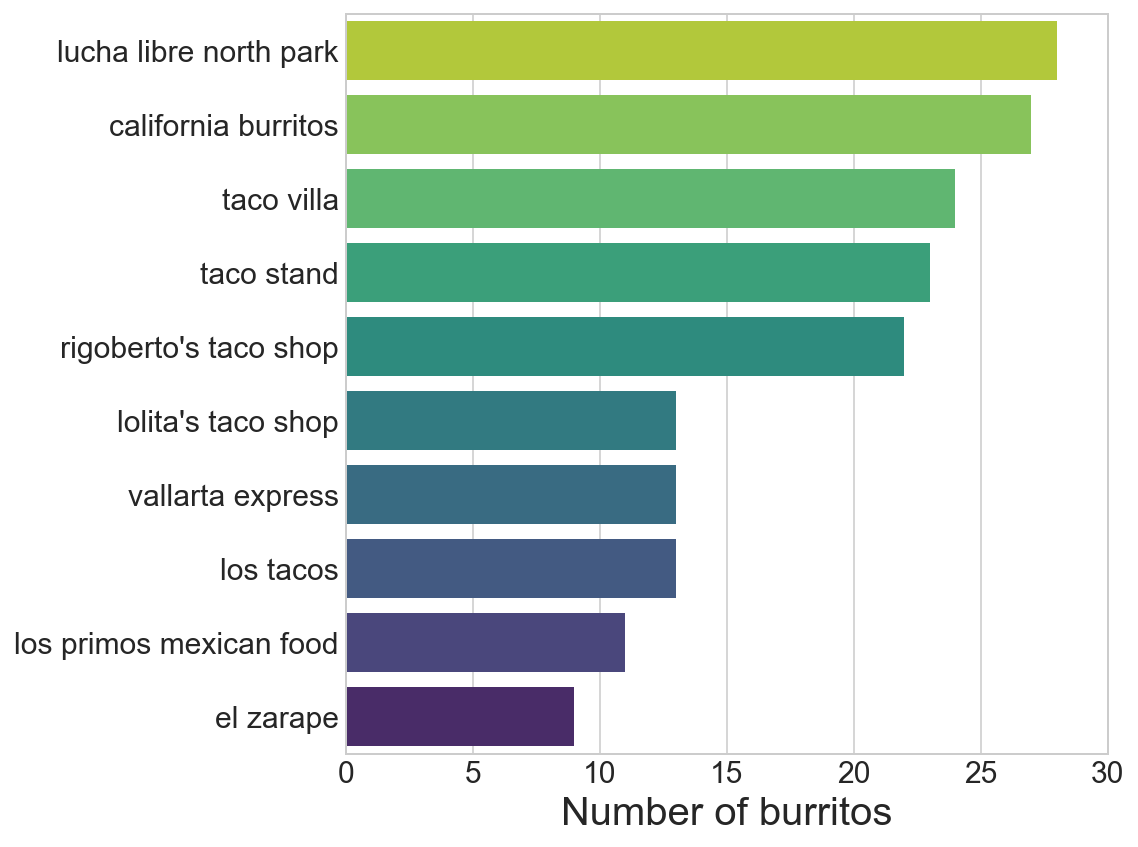

In [4]:
locs_keep = df['Location'].value_counts().index[:10]
df_plt = df[df['Location'].isin(locs_keep)]

plt.figure(figsize=(8,6))
sns.countplot(y='Location', data=df_plt, order=df_plt['Location'].value_counts().index, palette='viridis_r')
plt.xlabel('Number of burritos', size=20)
plt.ylabel('')
plt.xticks(np.arange(0,35,5), size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/burritocounts.png')

# 2. Word cloud

(-0.5, 809.5, 749.5, -0.5)

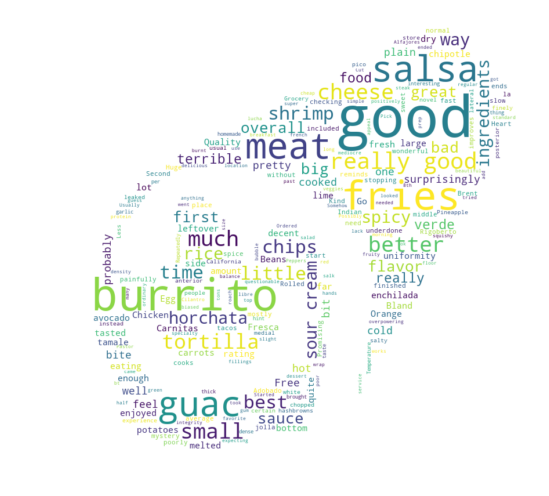

In [5]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS

# Get text of notes
text = ' '.join(df['Notes'].dropna().values)

# read the mask image. Mask from Creative Stall on Noun Project
burrito_mask = np.array(Image.open('/gh/fig/burritoposter/burritomask.png'))

# generate word cloud without stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")
wc = WordCloud(background_color="white", max_words=2000, mask=burrito_mask,
               stopwords=stopwords)
wc.generate(text)

# store to file
wc.to_file('/gh/fig/burritoposter/wordcloud.png')

# show
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")

# 3. Feature Distributions

Average burrito cost:  $ 6.97
Average burrito volume: 0.79 L
Average overall rating: 3.55


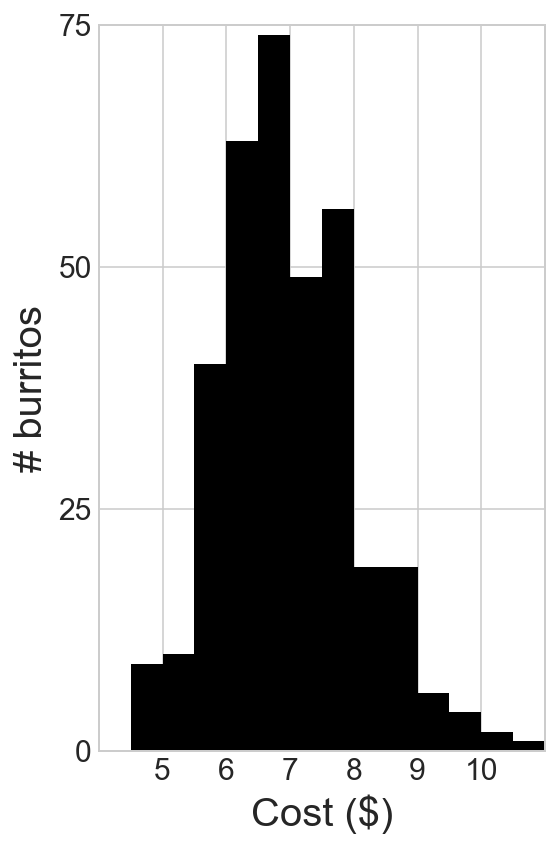

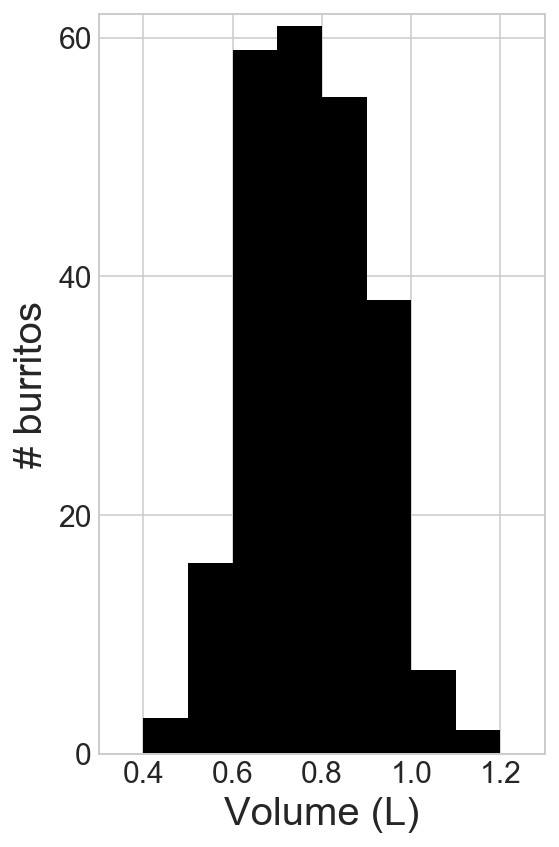

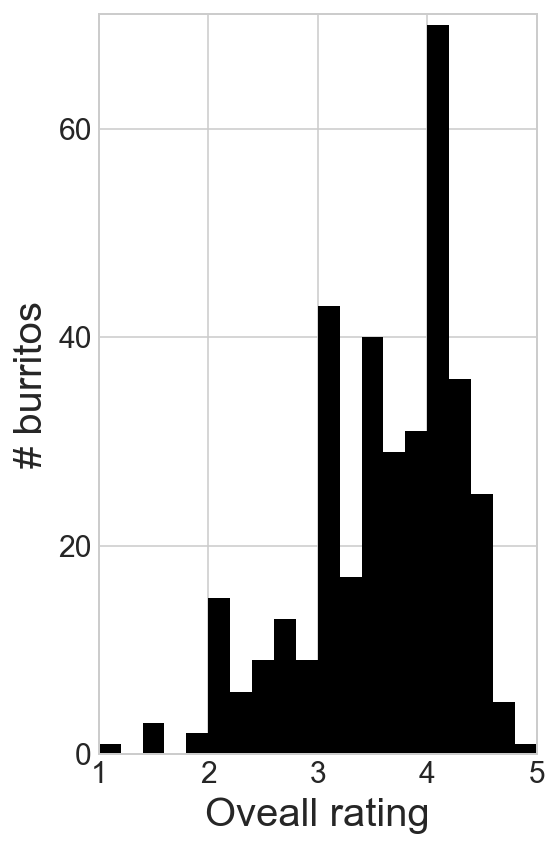

In [6]:
plt.figure(figsize=(4, 6))
n, _, _ = plt.hist(df.Cost.dropna(),np.arange(4,11.25,.50),color='k')
plt.xlabel('Cost ($)', size=20)
plt.ylabel('# burritos', size=20)
plt.xticks(np.arange(5,11,1),size=15)
plt.yticks(np.arange(0,100,25),size=15)
plt.xlim((4,11))
plt.ylim((0,75))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/dist_cost.png')

plt.figure(figsize=(4, 6))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(.3, 1.3, .1),color='k')
plt.xlabel('Volume (L)', size=20)
plt.ylabel('# burritos', size=20)
plt.xticks(np.arange(.4,1.4,.2),size=15)
plt.yticks(np.arange(0,70, 20),size=15)
plt.xlim((.3,1.3))
plt.ylim((0,62))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/dist_volume.png')

plt.figure(figsize=(4, 6))
n, _, _ = plt.hist(df.overall.dropna(),np.arange(1, 5.1, .2),color='k')
plt.xlabel('Oveall rating', size=20)
plt.ylabel('# burritos', size=20)
plt.xticks(np.arange(1, 5.1, 1),size=15)
plt.yticks(np.arange(0,70, 20),size=15)
plt.xlim((1,5))
plt.ylim((0,71))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/dist_overall.png')

print('Average burrito cost:  $', np.round(np.nanmean(df.Cost),2))
print('Average burrito volume: {:.2f} L'.format(np.nanmean(df.Volume)))
print('Average overall rating: {:.2f}'.format(np.nanmean(df.overall)))

# 4. Ranking of taco shops by overall rating

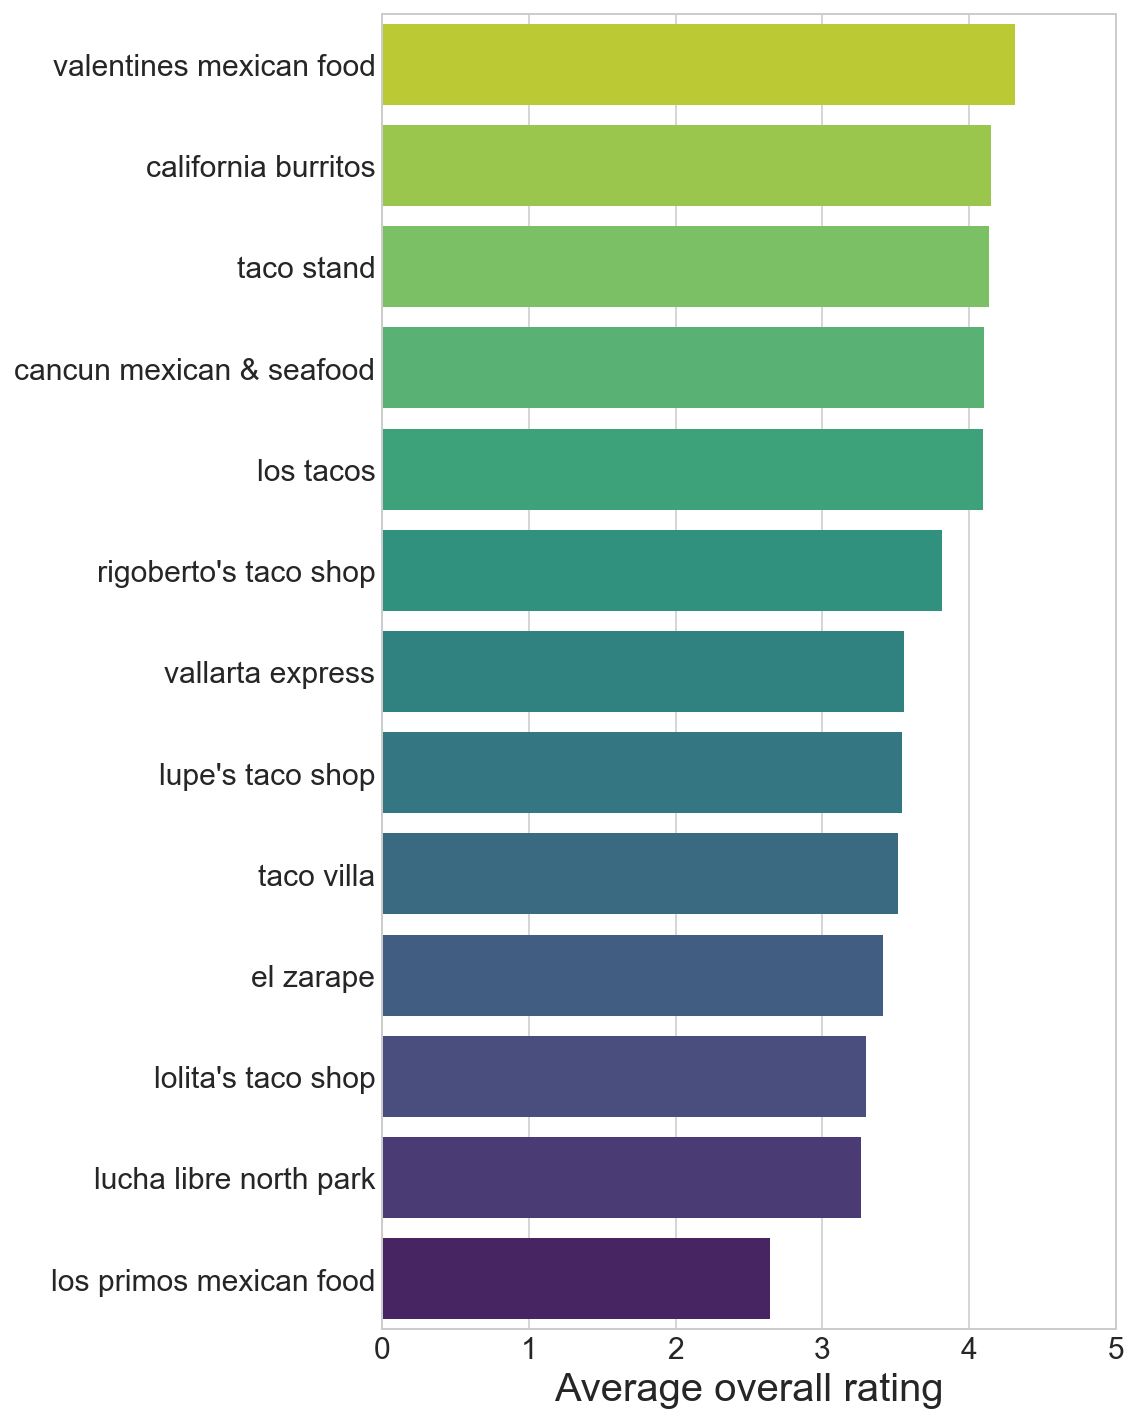

In [7]:
# Limit analysis to Locations with at least N burritos
minN = 5
shops_counts = df['Location'].value_counts()
shops_keep = shops_counts[shops_counts>minN].index
df_best = df[df.Location.isin(shops_keep)]
overall_ranks = df_best.groupby('Location').mean()['overall'].sort_values(ascending=False)
df_overall = overall_ranks.reset_index()

plt.figure(figsize=(8,10))
sns.barplot(y='Location', x='overall', data=df_overall, palette='viridis_r')
plt.xlim((0,5))
plt.yticks(size=15)
plt.xticks(np.arange(6), size=15)
plt.xlabel('Average overall rating', size=20)
plt.ylabel('')

plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/overall_rank.png')

# 5. Best taco shops for each burrito dimension

In [8]:
# Determine average rating for each feature for each taco shop
df_ratings = df[['Location','overall','Volume','Tortilla','Temp','Meat','Fillings',
                 'Meat:filling', 'Uniformity', 'Salsa', 'Synergy','Wrap', 'Value']]
mean_ratings_by_shop = df_ratings.groupby('Location').mean()
mean_ratings_by_shop['N'] = df['Location'].value_counts()

# Limit to taco shops with a minimum number of ratings
min_ratings = 5
mean_ratings_by_shop = mean_ratings_by_shop[mean_ratings_by_shop['N'] >= min_ratings]

# Compute ranking for each taco shop
shop_rankings = mean_ratings_by_shop.rank(ascending=0)
shop_rankings = shop_rankings.drop('N', axis=1)

# Make dataframe of the top taco shops in each dimension
dims = shop_rankings.keys()
max_rank = 5
rank_dfs = {}

for i, dim in enumerate(dims):
    rank_dict = {'shop':[0]*max_rank, 'rank':[0]*max_rank, 'average':[0]*max_rank}
    rank_sort = shop_rankings[dim].sort_values()[:max_rank]
    for j, shop in enumerate(rank_sort.keys()):
        rank_dict['shop'][j] = shop
        rank_dict['rank'][j] = int(rank_sort[shop])
        rank_dict['average'][j] = np.round(mean_ratings_by_shop[dim][shop],2)
    rank_dfs[dim] = pd.DataFrame.from_dict(rank_dict)
    rank_dfs[dim] = rank_dfs[dim].set_index('rank')
    rank_dfs[dim] = rank_dfs[dim][['shop','average']]
    
# Display best taco shops in each dimension
for dim in dims:
    print('\n\nRANKINGS FOR:',dim,'rating')
    print(rank_dfs[dim])



RANKINGS FOR: overall rating
                          shop  average
rank                                   
1      valentines mexican food     4.31
2          california burritos     4.15
3                   taco stand     4.13
4     cancun mexican & seafood     4.10
5                    los tacos     4.09


RANKINGS FOR: Volume rating
                        shop  average
rank                                 
1           lupe's taco shop     1.09
2      rigoberto's taco shop     0.92
3           vallarta express     0.90
4                  los tacos     0.83
5     lucha libre north park     0.83


RANKINGS FOR: Tortilla rating
                          shop  average
rank                                   
1      valentines mexican food     4.06
2     cancun mexican & seafood     4.05
3                  los tacos 2     3.90
4          california burritos     3.88
5                   taco stand     3.78


RANKINGS FOR: Temp rating
                            shop  average
rank       

# 6. Correlation matrix

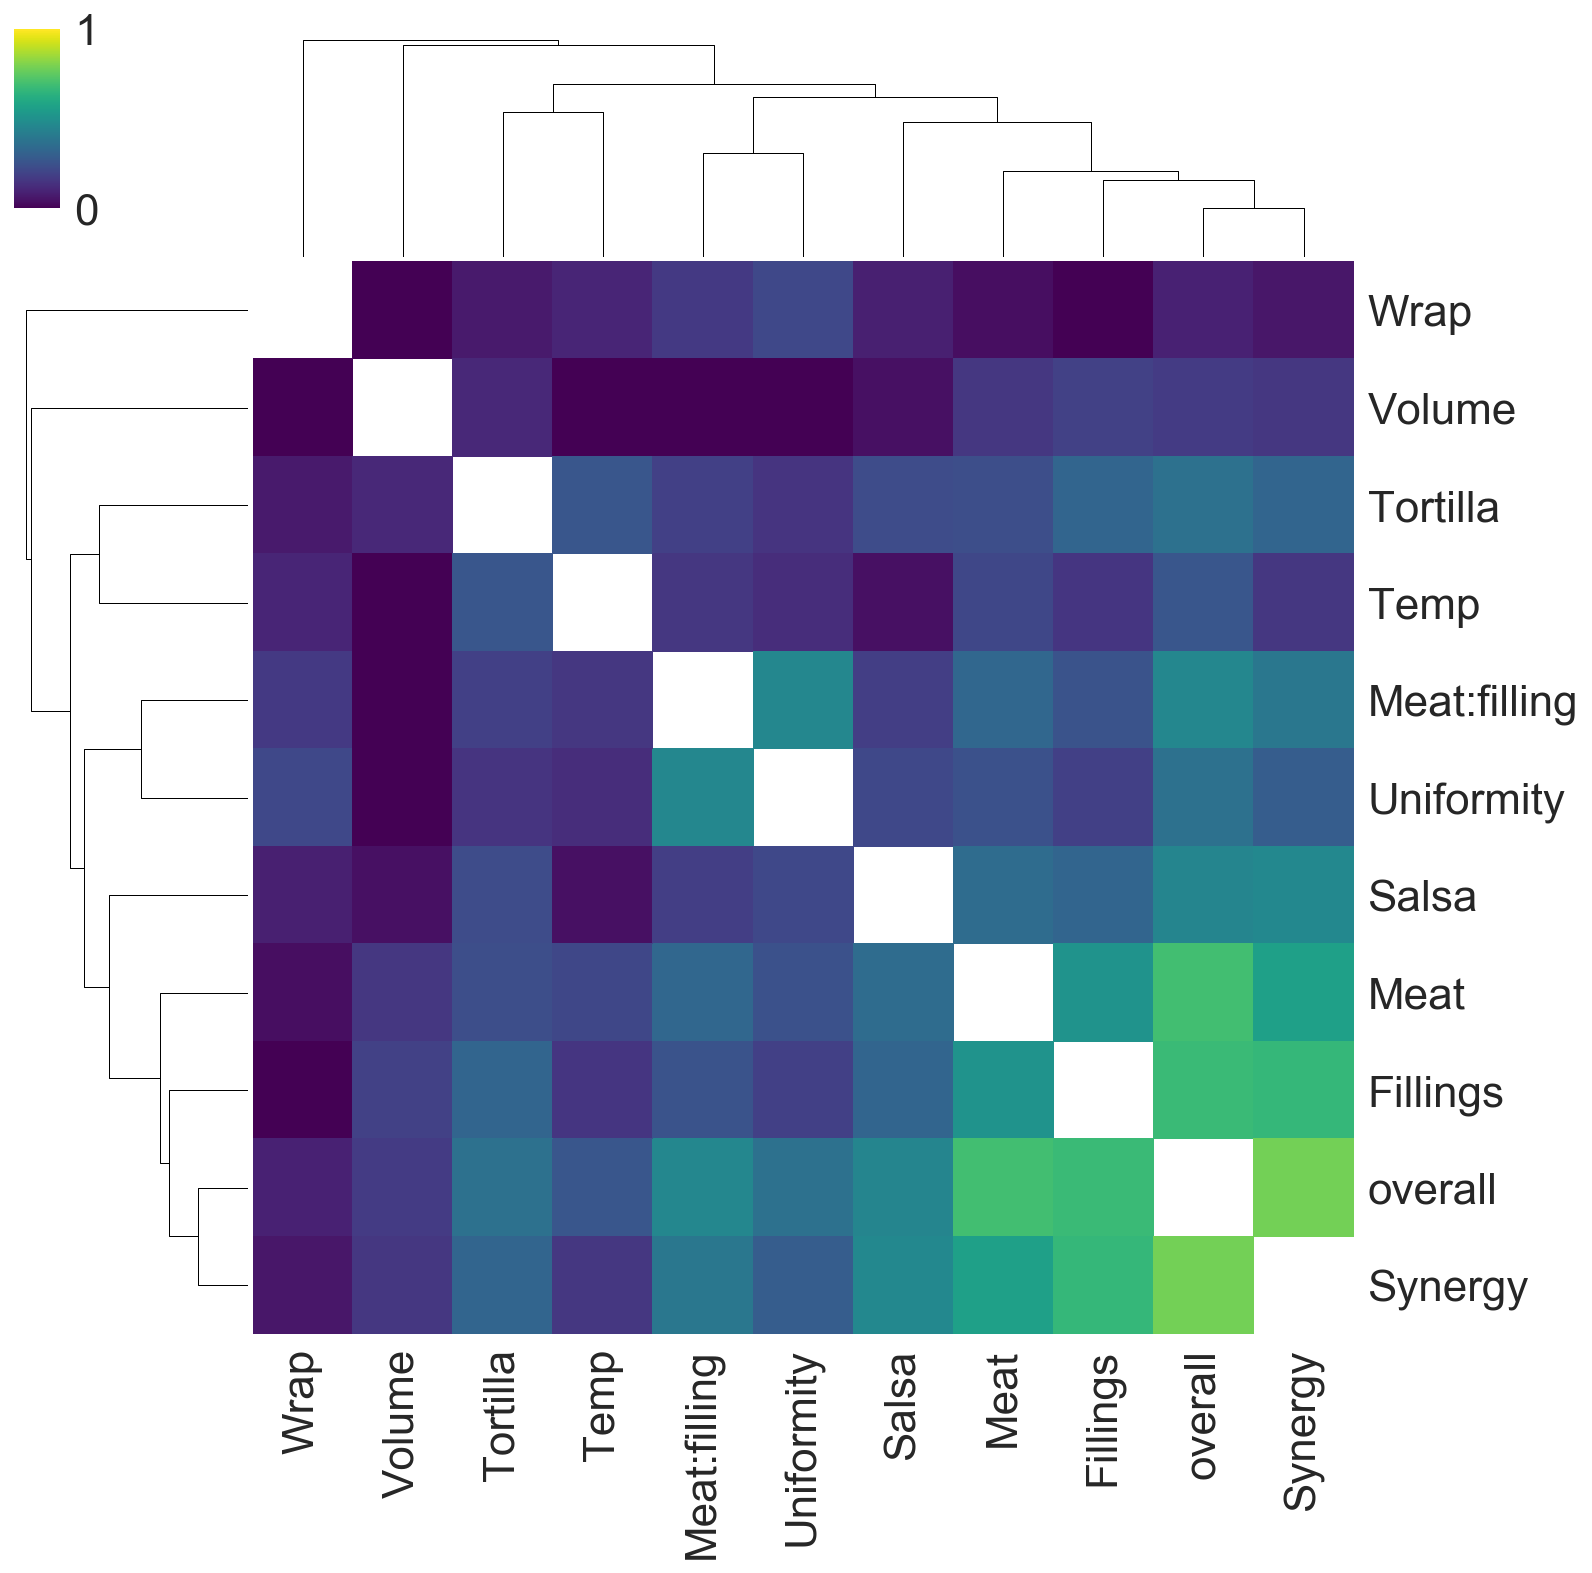

In [9]:
feat_corr = ['overall','Volume','Tortilla','Temp','Meat','Fillings',
             'Meat:filling', 'Uniformity', 'Salsa', 'Synergy','Wrap']
df_plt = df[feat_corr]
df_corrplt = df_plt.corr(method='spearman')

df_temp = df_corrplt.copy()
for feat1 in df_corrplt.columns:
    for feat2 in df_corrplt.columns:
        if feat1 == feat2:
            df_temp.loc[feat1,feat2] = True
        else:
            df_temp.loc[feat1,feat2] = False

sns.set(font_scale=2.2)
sns.set_style('whitegrid')
g = sns.clustermap(df_corrplt, vmin=0, vmax=1, cmap='viridis', mask=df_temp,
                   figsize=(12,12), cbar_kws={'ticks':[0,1]})
plt.savefig('/gh/fig/burritoposter/corrmat.png')

# 7. General linear model to predict overall rating from burrito features

In [10]:
# Define predictors of the model
m_lm = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Wrap','Cost']
cols_keep = np.hstack((m_lm,'overall'))

# Determine burritos rated by scott and not
df_scott = df[df['Reviewer']=='scott']
df_notscott = df[df['Reviewer']!='scott']

# Prep GLM
df_scott_glm = df_scott[cols_keep].dropna()
X = sm.add_constant(df_scott_glm[m_lm])
y = df_scott_glm['overall']

# Run GLM
my_glm = sm.GLM(y,X)
res_scott = my_glm.fit()
print(res_scott.summary())


# Prep GLM
df_notscott_glm = df_notscott[cols_keep].dropna()
X = sm.add_constant(df_notscott_glm[m_lm])
y = df_notscott_glm['overall']

# Run GLM
my_glm = sm.GLM(y,X)
res_notscott = my_glm.fit()
print(res_notscott.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                overall   No. Observations:                  128
Model:                            GLM   Df Residuals:                      118
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:              0.0985505244249273
Method:                          IRLS   Log-Likelihood:                -28.118
Date:                Wed, 18 Apr 2018   Deviance:                       11.629
Time:                        18:23:58   Pearson chi2:                     11.6
No. Iterations:                     2                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4777      0.302     -1.581      0.114      -1.070       0.115
Tortilla         0.1158      0.039      2.935 

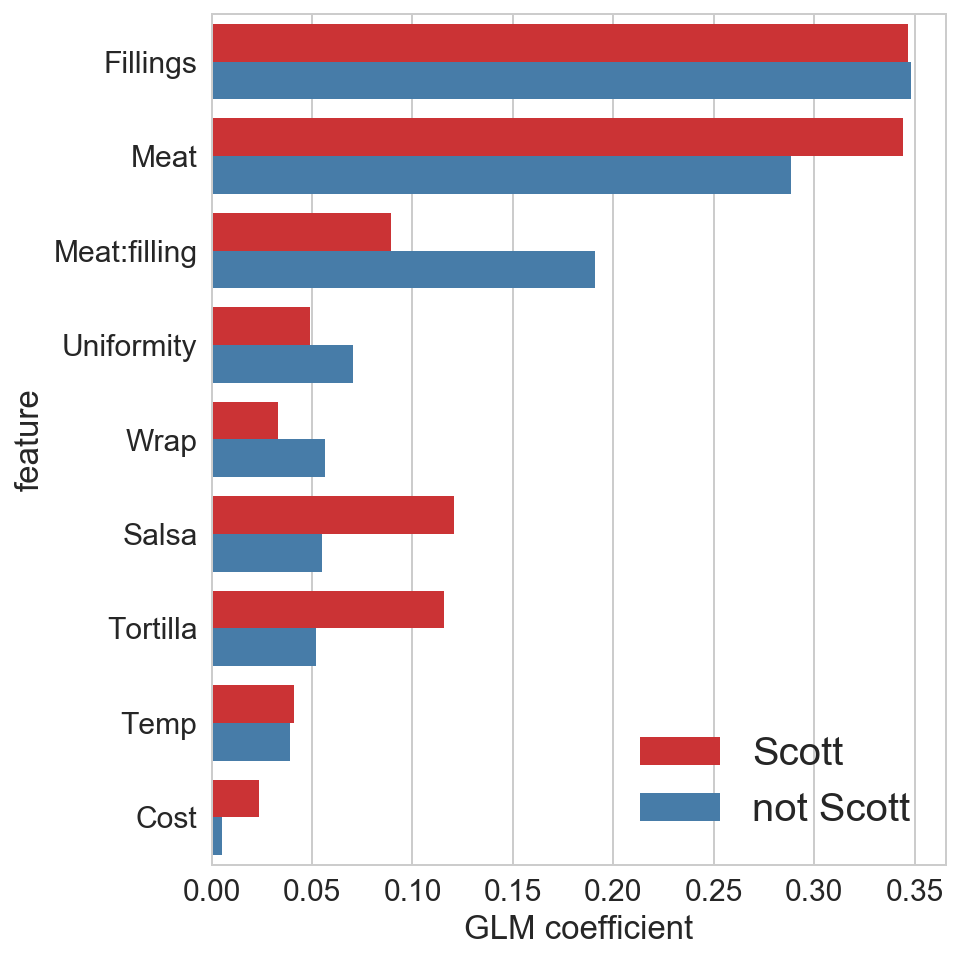

In [11]:
df_paramspre = pd.DataFrame({'Scott':res_scott.params, 'not Scott': res_notscott.params}).drop('const')
df_params = df_paramspre.stack().reset_index().rename(columns={
    'level_0':'feature', 'level_1':'is_scott', 0:'GLM coefficient'})

plt.figure(figsize=(7,7))
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.barplot(y='feature', x='GLM coefficient', hue='is_scott', data=df_params, palette='Set1',
            order=df_paramspre['not Scott'].sort_values(ascending=False).index)
plt.legend(title='', fontsize=(20))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/GLM coefs.png')


# 8. Within and across taco shop variance

,across shop,within : across,within shop
Volume,0.015218,0.820108,0.012480
Cost,1.151392,0.373395,0.429924


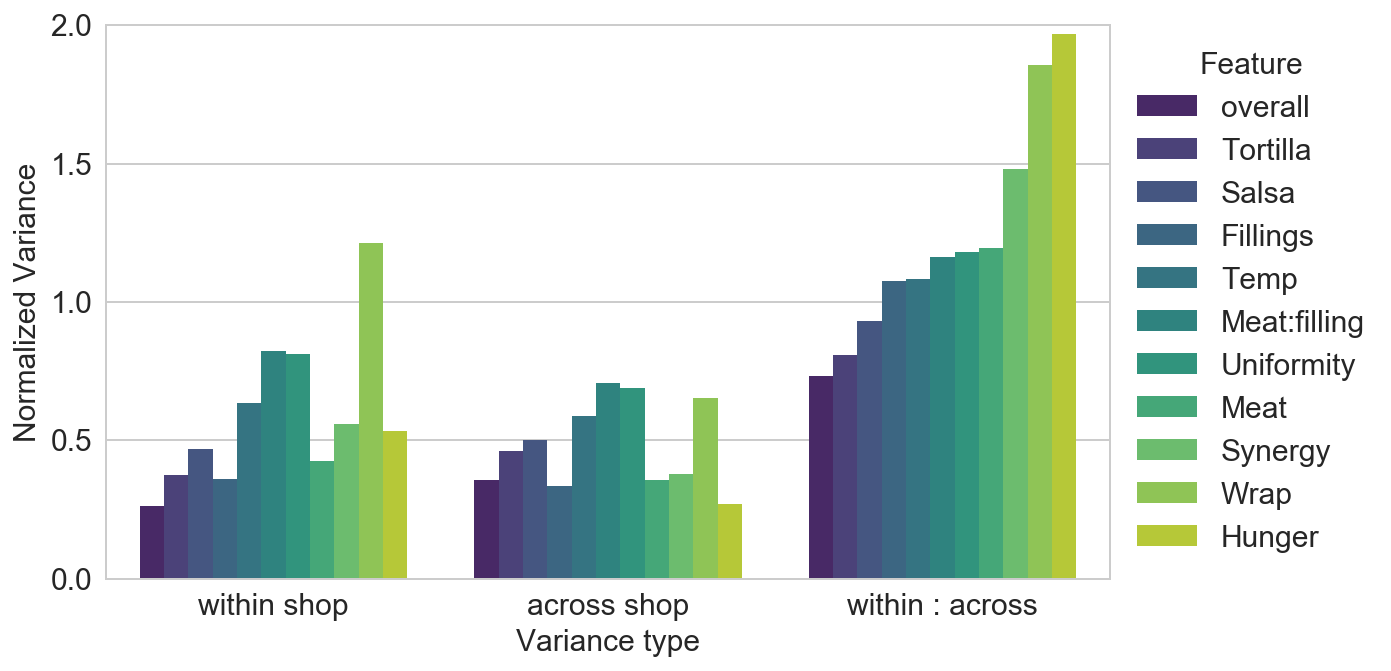

In [12]:
feats = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall', 'Hunger']

# Compute variance within restaurants
var_within_rest = df.groupby('Location')[feats].var().mean()
var_across_rest = df.groupby('Location')[feats].mean().var()
var_within_by_across = var_within_rest / var_across_rest

df_var = pd.DataFrame({'within shop': var_within_rest,
                       'across shop': var_across_rest, 
                       'within : across': var_within_by_across})
df_var = df_var.stack().reset_index().rename(columns={'level_0':'Feature', 'level_1': 'type', 0: 'Variance'})

plt.figure(figsize=(10,5))
sns.barplot(x='type', y='Variance', hue='Feature', data=df_var, palette='viridis',
            hue_order=var_within_by_across.sort_values().index,
            order = ['within shop', 'across shop', 'within : across'])
plt.gca().legend(title='Feature', fontsize=15, loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(plt.gca().get_legend().get_title(), fontsize='15')
plt.xlabel('Variance type', size=15)
plt.ylabel('Normalized Variance', size=15)
plt.xticks(size=15)
plt.yticks(np.arange(0, 2.5, .5), size=15)
plt.ylim((0,2))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/variance_within_across.png')

feats = ['Volume', 'Cost']

# Compute variance within restaurants
var_within_rest = df.groupby('Location')[feats].var().mean()
var_across_rest = df.groupby('Location')[feats].mean().var()
var_within_by_across = var_within_rest / var_across_rest
df_var = pd.DataFrame({'within shop': var_within_rest,
                       'across shop': var_across_rest, 
                       'within : across': var_within_by_across})
df_var.head()

# 9. Within and across taco shop correlation: meat and filling flavor

SpearmanrResult(correlation=0.5787517509556592, pvalue=2.8545938421030643e-08)


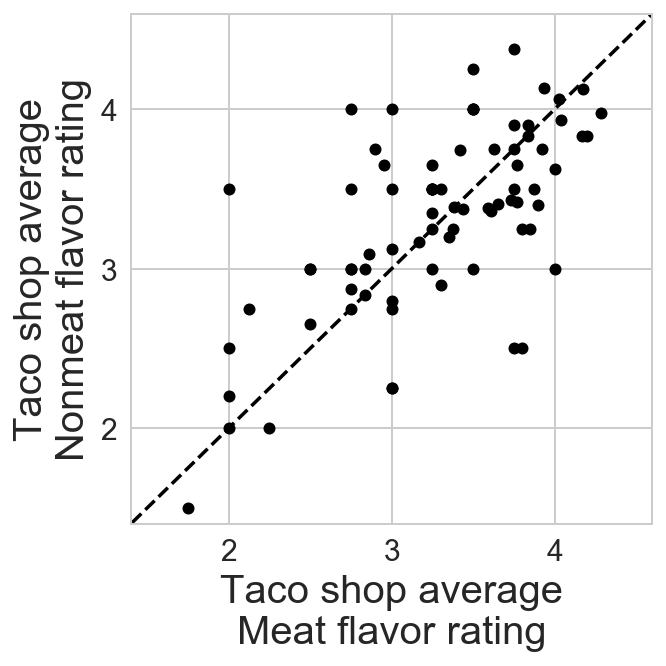

In [13]:
# Plot across-shop relationship
df_rest = df.groupby('Location')[['Meat', 'Fillings']].mean()

plt.figure(figsize=(5,5))
plt.plot(df_rest['Meat'], df_rest['Fillings'], 'k.', ms=12)
plt.plot([1,5],[1,5], 'k--')
plt.xlim((1.4,4.6))
plt.ylim((1.4,4.6))
plt.xticks(np.arange(2,5), size=15)
plt.yticks(np.arange(2,5), size=15)
plt.xlabel('Taco shop average\nMeat flavor rating', size=20)
plt.ylabel('Taco shop average\nNonmeat flavor rating', size=20)
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/meat_fillings_corr_across_shop.png')

print(stats.spearmanr(df_rest['Meat'], df_rest['Fillings']))

lucha libre north park SpearmanrResult(correlation=0.6310512306877477, pvalue=0.0007185440501772327)
california burritos SpearmanrResult(correlation=0.357121901862405, pvalue=0.07329256339548168)
taco villa SpearmanrResult(correlation=0.22917040431843344, pvalue=0.29286730215198686)
taco stand SpearmanrResult(correlation=0.6066001081279933, pvalue=0.0021497096741461635)
rigoberto's taco shop SpearmanrResult(correlation=0.8594233548309381, pvalue=6.023558987764323e-07)


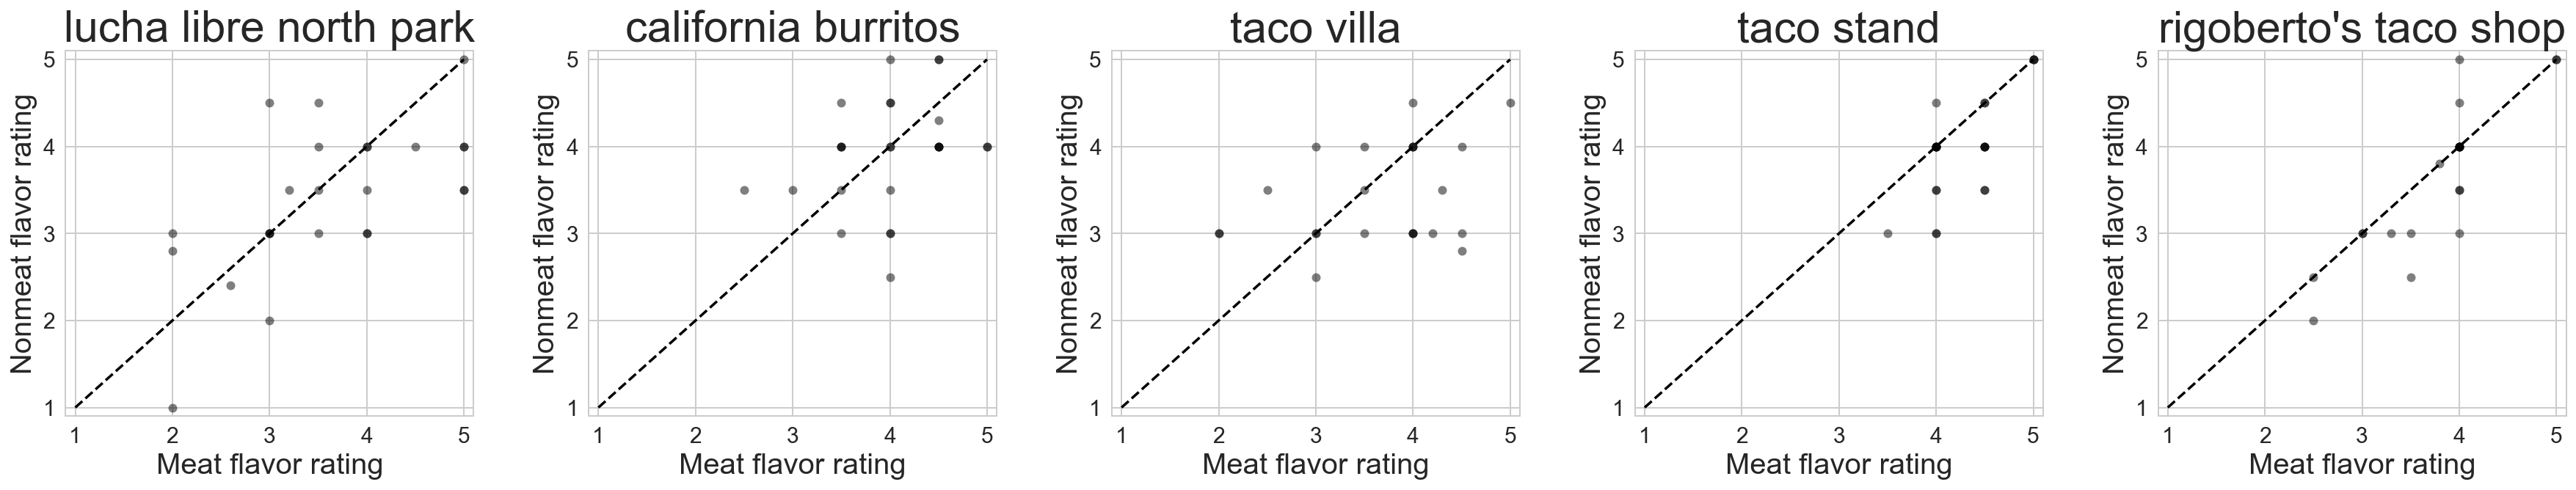

In [14]:
# Determine taco shops to plot

# Plot within-shop relationship
N = 5
plt.figure(figsize=(N*5,5))
shops_plt = df['Location'].value_counts().index[:N]
for i, (shop, color) in enumerate(zip(shops_plt, ['k','r','b', 'm', 'y'])):
    plt.subplot(1, N, i+1)
    df_plt = df[df['Location']==shop]
    plt.plot(df_plt['Meat'], df_plt['Fillings'], 'k.', ms=12, alpha=.5)

    df_corr = df_plt[['Meat', 'Fillings']].dropna()
    print(shop, stats.spearmanr(df_corr['Meat'], df_corr['Fillings']))
    plt.plot([1,5],[1,5], 'k--')
    plt.xlim((.9,5.1))
    plt.ylim((.9,5.1))
    plt.xticks(np.arange(1,6), size=15)
    plt.yticks(np.arange(1,6), size=15)
    plt.xlabel('Meat flavor rating', size=20)
    plt.ylabel('Nonmeat flavor rating', size=20)
    plt.title(shop, size=30)
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/meat_fillings_corr_within_shop.png')


# 10. Principal component analysis

In [15]:
# Determine features to use in computing prinicple components
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling',
            'Uniformity','Salsa','Synergy','Wrap']]

# Replace NaN with mean value (mainly applies to ratings missing Volume measurement)
dfpca = dfpca.fillna(dfpca.mean())

# Normalize each dimension
dfpca = (dfpca - dfpca.mean()) / dfpca.std()

# Apply PCA
pca = PCA(n_components=2)
pca.fit(dfpca)

# Display principal components
pcinfo = {}
pcinfo['Burrito dimension'] = dfpca.keys()
pcinfo['Component 1 weight'] = pca.components_[0]
pcinfo['Component 2 weight'] = pca.components_[1]
print(pd.DataFrame.from_dict(pcinfo).sort_values(by='Component 2 weight', ascending=False))
print('\nExplained variance from first 2 PCs:', pca.explained_variance_ratio_)

  Burrito dimension  Component 1 weight  Component 2 weight
0            Volume           -0.033523            0.571427
4          Fillings           -0.419903            0.260132
3              Meat           -0.407061            0.195220
8           Synergy           -0.468154            0.132862
7             Salsa           -0.309925            0.066024
1          Tortilla           -0.296822            0.027868
2              Temp           -0.188675           -0.136572
5      Meat:filling           -0.342476           -0.296532
6        Uniformity           -0.297002           -0.371569
9              Wrap           -0.111518           -0.547958

Explained variance from first 2 PCs: [0.3192391  0.13418206]


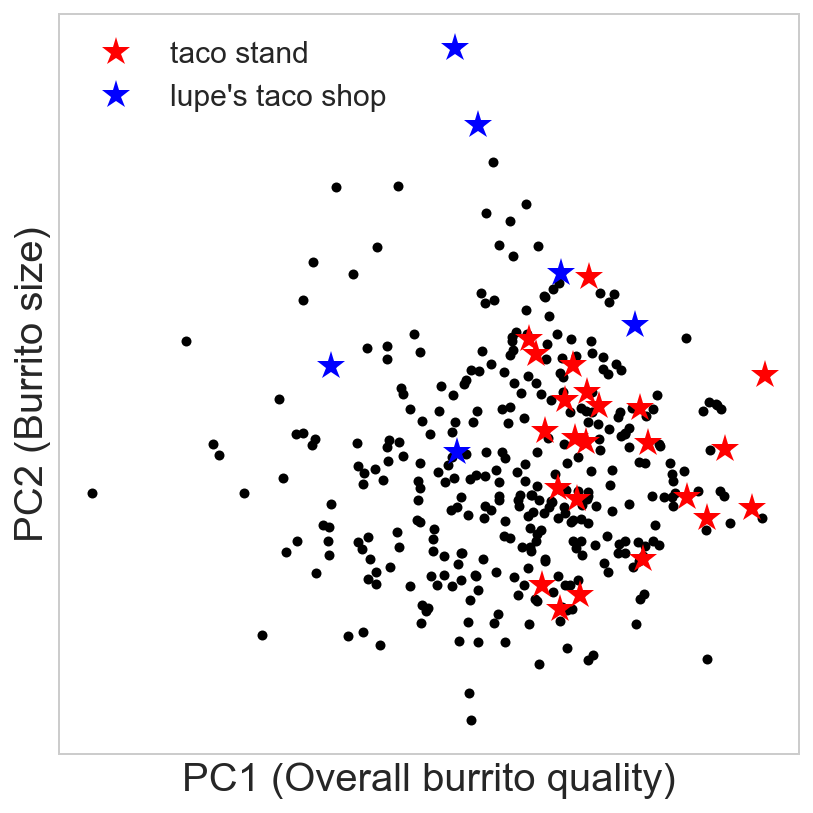

In [16]:
# Project data into PC space
dfpca_proj = np.dot(pca.components_,dfpca.T)

# Plot each burrito in PC space
plt.figure(figsize=(6,6))
plt.plot(-dfpca_proj[0],dfpca_proj[1],'k.',ms=10)
plt.xlabel('PC1 (Overall burrito quality)',size=20)
plt.ylabel('PC2 (Burrito size)', size=20)
plt.xticks([])
plt.yticks([])

# Plot some taco shops in separate colors
shops = ['taco stand',"lupe's taco shop"]
colors = ['r','b']
for i, s in enumerate(shops):
    burridx = np.argwhere(df.Location==s)
    plt.plot(-dfpca_proj[0][burridx],dfpca_proj[1][burridx],'*',color=colors[i],ms=15,label=s)
plt.legend()
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/pca.png')

# 11. Inter-reviewer reliability

In [17]:
# Group ratings by location and burrito type
foi = ['Tortilla', 'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity',
       'Salsa', 'Synergy', 'Wrap', 'overall']
cols_keep = np.append(foi, ['Location', 'Burrito', 'Reviewer', 'Date'])
df2 = df[cols_keep].dropna(axis=0).reset_index(drop=True)
burrito_groups = df2.groupby(['Location', 'Burrito']).groups

# For each burrito group, make pairs of ratings
burrito_pairs_idxs = []
for k, idxs in burrito_groups.items():

    # Only consider burrito groups with more than 1 rating
    if len(idxs) >= 2:
        
        # Only consider burrito groups with more than 1 distinct reviewer and date
        reviewer_array = df2.loc[idxs]['Reviewer'].values
        date_array = df2.loc[idxs]['Date'].values
        if len(np.unique(reviewer_array)) > 1 and len(np.unique(date_array)) > 1:
            
            # Make new pairs as long as possible
            pairing_reviewers = np.copy(reviewer_array)
            pairing_dates = np.copy(date_array)
            pairing_idxs = np.copy(idxs)
            can_make_pair = True
            while can_make_pair:
                
                # Cannot make pair if less than 2 unique dates, or 2 unique reviewers
                if len(np.unique(pairing_reviewers)) < 2 and len(np.unique(pairing_dates)) < 2:
                    can_make_pair = False

                else:
                    # Choose the first rating
                    rating1_i = pairing_idxs[0]
                    rating1_rev = pairing_reviewers[0]
                    rating1_date = pairing_dates[0]
                    
                    # Choose a rating that can go with this one
                    for i in range(1,len(pairing_idxs)):
                        rating2_i = pairing_idxs[i]
                        rating2_rev = pairing_reviewers[i]
                        rating2_date = pairing_dates[i]
                        
                        # If the pair of ratings is valid, then save the pair of rating indices
                        if (rating1_rev != rating2_rev) and (rating1_date != rating2_date):
                            burrito_pairs_idxs.append([rating1_i, rating2_i])
                            
                            # Remove the paired indices from the list of reviews to pair
                            pairing_reviewers = np.delete(pairing_reviewers, [0, i])
                            pairing_dates = np.delete(pairing_dates, [0, i])
                            pairing_idxs = np.delete(pairing_idxs, [0, i])
                            break

                        # Delete the first index if no pairings worked
                        if i == len(pairing_idxs)-1:
                            pairing_reviewers = np.delete(pairing_reviewers, 0)
                            pairing_dates = np.delete(pairing_dates, 0)
                            pairing_idxs = np.delete(pairing_idxs, 0)
                            

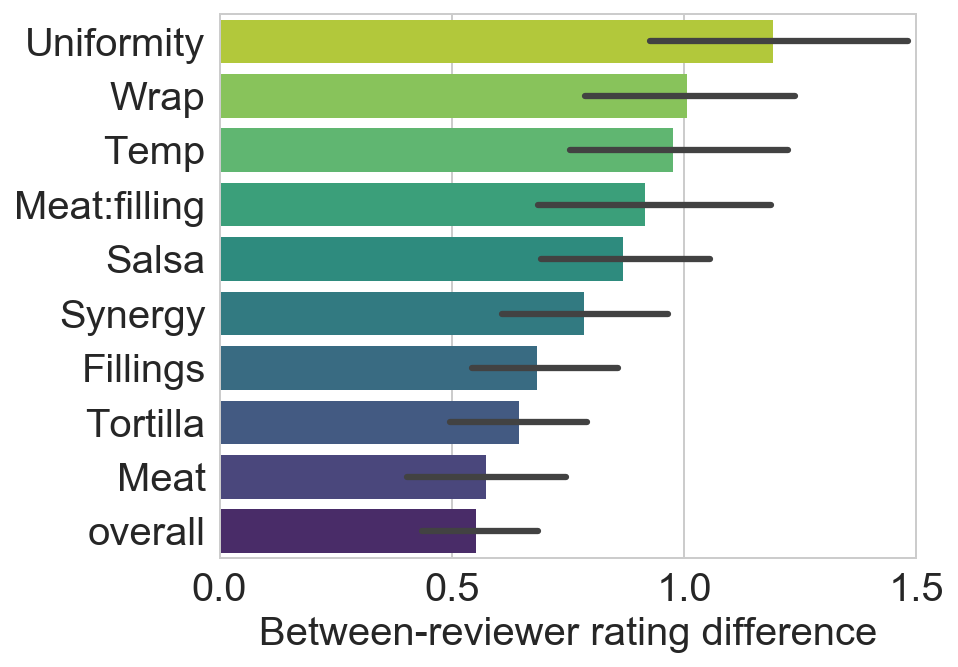

In [18]:
# Compute feature differences for each pair
df_feat = df2[foi]
N_pairs = len(burrito_pairs_idxs)
df_feat_diffs = pd.DataFrame()
for i in range(N_pairs):
    feature_diffs = np.abs(df_feat.loc[burrito_pairs_idxs[i][0]] - df_feat.loc[burrito_pairs_idxs[i][1]])
    df_feat_diffs = df_feat_diffs.append(feature_diffs, ignore_index=True)
    
# Plot average difference in order
df_plt = df_feat_diffs.stack().reset_index().drop('level_0', axis=1).rename(columns={'level_1':'feature', 0: 'diff'})
plt.figure(figsize=(7,5))
sns.barplot(y='feature', x='diff', data=df_plt, order=df_feat_diffs.mean().sort_values(ascending=False).index,
            palette='viridis_r')
plt.xlabel('Between-reviewer rating difference', size=20)
plt.ylabel('')
plt.xticks(np.arange(0,2,.5), size=20)
plt.yticks(size=20)
plt.xlim((0,1.5))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/reliability_by_feature.png')

In [19]:
# Simulate differences between random burrito pairings
np.random.seed(0)
N_sim = 1000 # Number of simulated burrito pairings

# Choose a random reviewer for each simulation
sim_rating1_options = np.hstack(burrito_pairs_idxs)
sim_rating1 = np.random.choice(sim_rating1_options, N_sim)
    
# Compute feature differences for random burritos
feat_diffs_null = defaultdict(list)
for i in range(N_sim):
    # Determine reviewer
    idx_rating1 = sim_rating1[i]
    rev1 = df2.loc[idx_rating1]['Reviewer']
    rest1 = df2.loc[idx_rating1]['Location']
    feats1 = df2.loc[idx_rating1].drop(['Location','Burrito','Reviewer','Date'])
    
    # Choose 2 valid random burritos from that reviewer
    got_2 = False
    while not got_2:
        # Choose another random burritos
        idx_rating2 = np.random.randint(len(df2))
        
        # Check if burritos are not from same restaurant
        rest2 = df2.loc[idx_rating2].Location
        rev2 = df2.loc[idx_rating2].Reviewer
        if (rest1 != rest2) and (rev1 != rev2):
            got_2 = True
            feats2 = df2.loc[idx_rating2].drop(['Location','Burrito','Reviewer','Date'])
            
    # Compute differences for each feature
    for k in feats1.keys():
        feat_diffs_null[k].append(np.abs(feats1[k] - feats2[k]))
df_feat_diff_null = pd.DataFrame(feat_diffs_null)

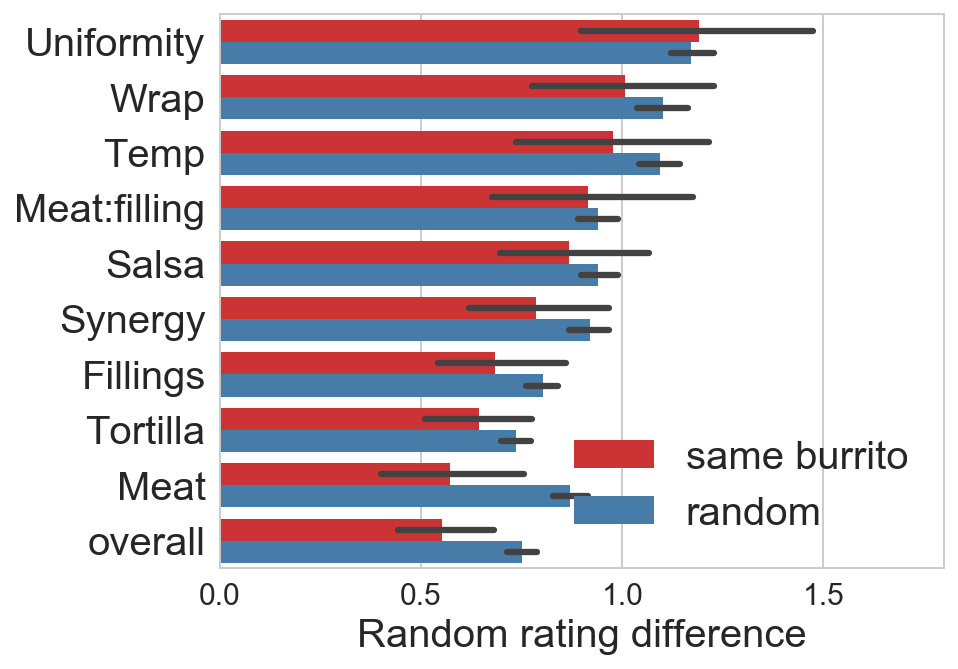

In [20]:
# Plot simulated and true paired rating differences together
df_feat_diffs['pairing'] = 'same burrito'
df_feat_diff_null['pairing'] = 'random'
df_plt = pd.concat([df_feat_diffs, df_feat_diff_null])

# Plot null average difference in order
df_plt = df_plt.set_index('pairing').stack().reset_index().rename(columns={'level_1':'feature', 0: 'diff'})
plt.figure(figsize=(7,5))
sns.barplot(y='feature', x='diff', hue='pairing', data=df_plt, palette='Set1',
            order=df_feat_diffs.mean().sort_values(ascending=False).index)
plt.xlabel('Random rating difference', size=20)
plt.ylabel('')
plt.legend(title='', fontsize=20)
plt.xticks(np.arange(0,2,.5), size=15)
plt.yticks(size=20)
plt.xlim((0,1.8))
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/reliability_by_feature_compared.png')

Feature     p-value
-------     -------
Fillings      0.095  
Meat          0.001  
Meat:filling  0.317  
Salsa         0.255  
Synergy       0.166  
Temp          0.171  
Tortilla      0.289  
Uniformity    0.466  
Wrap          0.478  
overall       0.025  


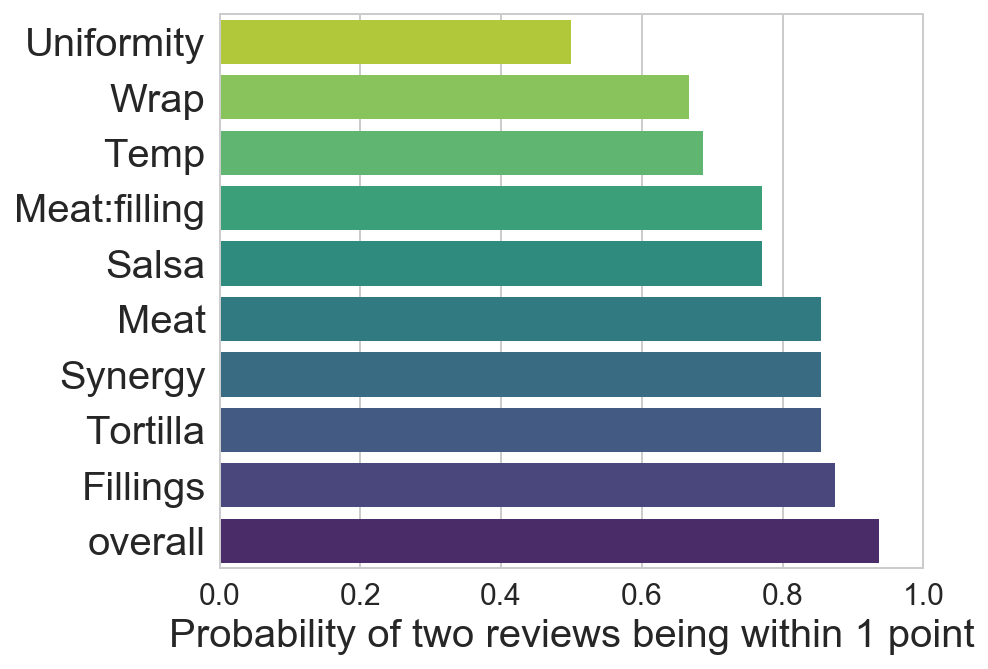

In [22]:
# Print stats
print('Feature     p-value\n-------     -------')
ps = {}
for k in df_plt['feature'].unique():
    t, ps[k] = sp.stats.mannwhitneyu(df_feat_diffs[k].values,feat_diffs_null[k])
    print('{: <14}{:.3f}  '.format(k, ps[k]))
    
# Plot probability that the two ratings are within 1 point
dict_prob1 = {}
for k in df_plt['feature'].unique():
    dict_prob1[k] = [np.mean(df_feat_diffs[k].values <= 1)]
df_plt = pd.DataFrame(dict_prob1)
df_plt = pd.DataFrame(df_plt.stack()).reset_index().drop('level_0', axis=1).rename(columns={'level_1':'feature', 0:'prob_within'})

plt.figure(figsize=(7,5))
sns.barplot(y='feature', x='prob_within', data=df_plt, palette='viridis_r',
            order=df_plt.sort_values('prob_within')['feature'])
plt.ylabel('')
plt.xlabel('Probability of two reviews being within 1 point', size=20)
plt.xticks(np.arange(0,1.1,.2), size=15)
plt.yticks(size=20)
plt.tight_layout()
plt.savefig('/gh/fig/burritoposter/reliability_within1.png')